# Multiclass Logistic Regression

 I used Cardiotocography Data Set from here:
 https://archive.ics.uci.edu/ml/datasets/cardiotocography

This data set consists of the fetal cardiotocograms results classified by fetal state (N = normal, S = suspect, P = pathologic) and by fetal heart rate morphologic pattern (A, B, C ...).

In [22]:
import os
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.linear_model
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

import seaborn as sns
plt.rc("font", size=14)
#sns.set(style="white")
#sns.set(style="whitegrid", color_codes=True)


In [23]:
np.random.seed(1)
path = os.path.join("data", "CTG.csv")
raw_df = pd.read_csv(path, sep=";")

### Attribute description:
- LB - FHR baseline (beats per minute)
- AC - # of accelerations per second
- FM - # of fetal movements per second
- UC - # of uterine contractions per second
- DL - # of light decelerations per second
- DS - # of severe decelerations per second
- DP - # of prolongued decelerations per second
- ASTV - percentage of time with abnormal short term variability
- MSTV - mean value of short term variability
- ALTV - percentage of time with abnormal long term variability
- MLTV - mean value of long term variability
- Width - width of FHR histogram
- Min - minimum of FHR histogram
- Max - Maximum of FHR histogram
- Nmax - # of histogram peaks
- Nzeros - # of histogram zeros
- Mode - histogram mode
- Mean - histogram mean
- Median - histogram median
- Variance - histogram variance
- Tendency - histogram tendency:(-1 = left assymetric; 0 = symmetric; 1 = right assymetric)
- CLASS - FHR pattern class code (1 to 10)
- NSP - fetal state class code (N=normal; S=suspect; P=pathologic)

### Remove unnecessary columns.
- FileName, Date, SegFile, b, e - these variables represent measurement metadata and are unnecessary for analysis.
- CLASS - The analysis will be performed against the fetus status variable ("NSP"), so "CLASS" variable is not needed.
- A, B, C, D, E (SH), AD, DE, LD, FS, SUSP - binary class variables related to "CLASS" 
- LBE - contains exactly the same values as LB


In [24]:
columns_to_remove = ["FileName", "Date", "SegFile","b","e","CLASS","A", "B", "C", "D", "E", "AD", "DE", "LD", "FS", "SUSP","LBE"]
df = raw_df.drop(columns_to_remove, axis=1)
print(df.shape)
print(list(df.columns))

(2126, 23)
['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 'NSP']


We need to check if the data set contains any null values. It seems that there aren't any.

In [25]:
df.isnull().sum()

LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
DR          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
NSP         0
dtype: int64

In [26]:
colors = ['c', 'y', 'r']
explode = (0, 0, 0.2)
labels = ("(1) Normal","(2) Suspected","(3) Pathological")
counts = df["NSP"].value_counts()
counts



1    1655
2     295
3     176
Name: NSP, dtype: int64

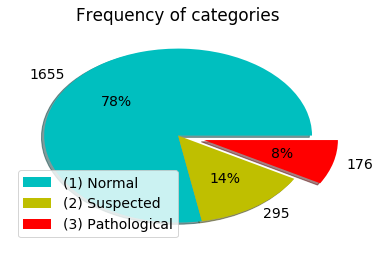

In [27]:
plt.pie(counts,labels=counts, shadow=True,colors=colors,explode=explode,autopct='%1.0f%%')
plt.title('Frequency of categories')
plt.legend(labels,loc=3)
plt.show()

There is one categorical, independent variable - __"Tendency"__. For k class values we should create k -1 dummy, indicator, binary variables.
All other variables are numeric.

In [28]:
dummies = pd.get_dummies(df["Tendency"],prefix="Tendency",prefix_sep="_")
dummies.drop(["Tendency_1"],axis=1,inplace=True)
df = pd.concat([df, dummies],axis=1).drop(["Tendency"],axis=1)
df.head()

LB  AC  FM  UC  ASTV  MSTV  ALTV  MLTV  DL  DS     ...      Max  Nmax  \
0  120   0   0   0    73   0.5    43   2.4   0   0     ...      126     2   
1  132   4   0   4    17   2.1     0  10.4   2   0     ...      198     6   
2  133   2   0   5    16   2.1     0  13.4   2   0     ...      198     5   
3  134   2   0   6    16   2.4     0  23.0   2   0     ...      170    11   
4  132   4   0   5    16   2.4     0  19.9   0   0     ...      170     9   

   Nzeros  Mode  Mean  Median  Variance  NSP  Tendency_-1  Tendency_0  
0       0   120   137     121        73    2            0           0  
1       1   141   136     140        12    1            0           1  
2       1   141   135     138        13    1            0           1  
3       0   137   134     137        13    1            0           0  
4       0   137   136     138        11    1            0           0  

[5 rows x 24 columns]

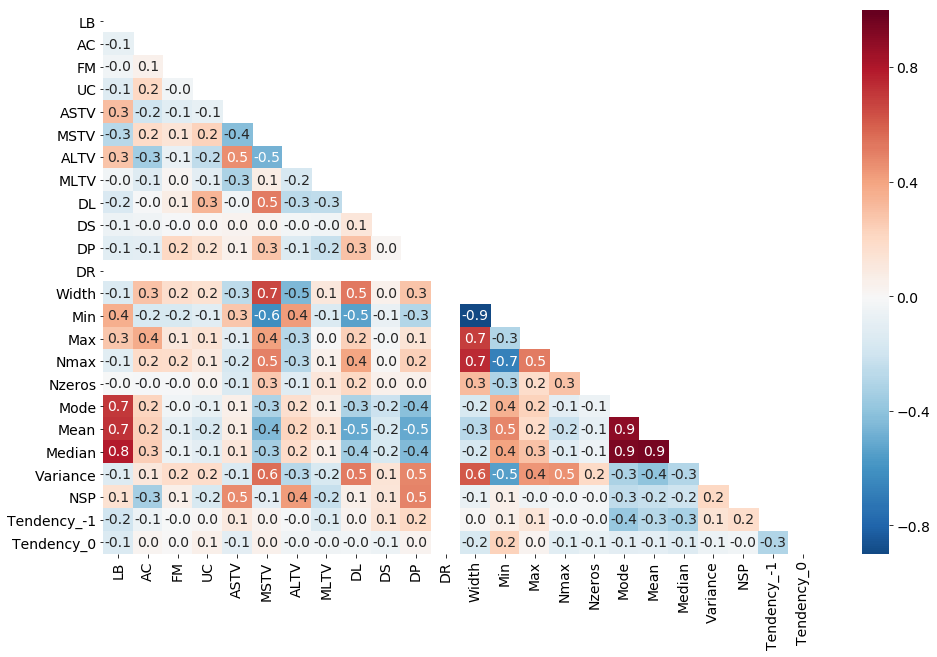

In [29]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(16, 10))
sns.heatmap(corr, mask=mask, center=0,cmap="RdBu_r", annot=True, fmt='.1f')
plt.show()

When we look at heatmap representing correlation matrix of variables, we can see that there is something wrong with "DR" variable. 

In [30]:
df["DR"].value_counts()

0    2126
Name: DR, dtype: int64

As we see, there is only one value of that variable. For this reason we should remove column "DR" from dataset, because it doesn't have any impact on results. 

In [31]:
df.drop(["DR"], axis=1, inplace=True)

As we also see on matrix above, there are some predictors that are corelated. 
We should try to reduce multicollinearity. One possible way is to perform Principal Component Analysis on dataset. Or we can try to reduce it by removing some predictors.

In [32]:
df.drop(["Mode","Median","Mean","Width"], axis=1, inplace=True)

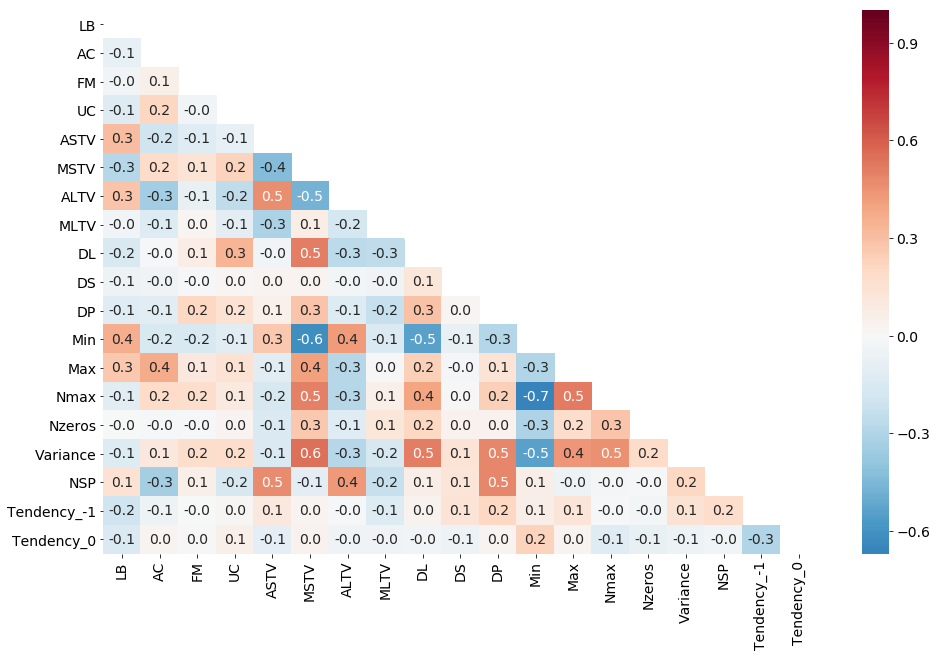

In [33]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(16, 10))
sns.heatmap(corr, mask=mask, center=0,cmap="RdBu_r", annot=True, fmt='.1f')
plt.show()

### Training and testing datasets
Divide the dataset into a training and test random subsets. 
I will show 2 different methods of that task.

More: https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas/24151789#

__1) sklearn module__

In [34]:
X = df.drop(["NSP"], axis=1)
y = df["NSP"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)

__2) pandas df.sample method__

In [35]:
train = df.sample(frac=0.7)
test = df.drop(train.index)

In [36]:
model = sklearn.linear_model.LogisticRegression()
model.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
predictions = model.predict(X_test)

Confusion matrix. Two methods.

In [38]:
# I method
pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)


Predicted    1   2   3  All
Actual                     
1          473  13   4  490
2           39  54   3   96
3            5  12  35   52
All        517  79  42  638

In [39]:
# with percents
pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted']).apply(lambda r: 100.0 * r/r.sum())

Predicted          1          2          3
Actual                                    
1          91.489362  16.455696   9.523810
2           7.543520  68.354430   7.142857
3           0.967118  15.189873  83.333333

In [40]:
# II method
confusion = confusion_matrix(y_test, predictions,labels=[1,2,3])
print(confusion)


[[473  13   4]
 [ 39  54   3]
 [  5  12  35]]


### Accuracy

In [41]:
print(f"Accuracy of logistic regression classifier on test set: {model.score(X_test, y_test):.2f}")

Accuracy of logistic regression classifier on test set: 0.88


In [42]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          1       0.91      0.97      0.94       490
          2       0.68      0.56      0.62        96
          3       0.83      0.67      0.74        52

avg / total       0.87      0.88      0.88       638



### Useful links
#### Regression
- https://onlinecourses.science.psu.edu/stat501/node/343/
- https://www.theanalysisfactor.com/linear-regression-analysis-3-common-causes-of-multicollinearity-and-what-do-to-about-them/
- https://datascienceplus.com/building-a-logistic-regression-in-python-step-by-step/

#### PCA:
- https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c
